## Model Evaluations
Purpose of this notebook is to evaluate the final models developed on the test dataset.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Capstone/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/Capstone/'
/content/gdrive/MyDrive/Capstone


In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 13.2MB/s 
     |████████████████████████████████| 901kB 59.7MB/s 
     |████████████████████████████████| 3.3MB 49.0MB/s 


In [81]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.metrics import classification_report, recall_score, f1_score, precision_score, precision_recall_curve, accuracy_score, confusion_matrix 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm

import transformers
from transformers import AdamW, get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup

from tqdm import tqdm, tqdm_notebook, tqdm_pandas

tqdm.pandas()
tqdm_notebook().pandas()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [82]:
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

In [12]:
user_type_df = pd.read_csv('data/total_user_type.csv') # dataframe containing the user types and the 
tf_score_df = pd.read_pickle('data/tf_score_df.pkl') # dataframe containing the TF-IDF scores

In [30]:
# with open('data/train_df_tlstm.pkl', 'rb') as f:
#   train_df = pickle.load(f)

# with open('data/test_df_tlstm.pkl', 'rb') as f:
#   test_df = pickle.load(f)

# with open('data/val_df_tlstm.pkl', 'rb') as f:
#   val_df = pickle.load(f)

# full_df = train_df.append(test_df).append(val_df)

with open('data/full_df.pkl', 'rb') as f:
    full_df = pickle.load(f)

In [79]:
full_df.head()

,username,hist_dates,combined_text,enc,label,type,split,tf_score,total_score
0,--Doc_Holliday,"[2019-03-29 10:23:09, 2019-04-18 21:40:49, 201...","[Ill take a copy if youre still offering!, I t...","[[-0.046786565, -0.009795629, -0.12904653, -0....",0,lfhn,train,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.442035
1,--NoIdeaWhatImDoing,"[2019-04-04 20:03:54, 2019-04-04 21:30:48, 201...",[Best brand of coffee to drink black? Hey all....,"[[-0.2573667, 0.31006807, -0.19334464, 0.03483...",0,lfln,train,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.172534
2,-AnxiousWallflower-,"[2019-12-17 13:04:08, 2019-12-28 18:38:51, 201...",[My cat does this with hair ties. It’s the cut...,"[[0.27901784, 0.6647909, 3.8793212e-05, 0.2140...",1,lfln,train,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.884020
3,-Arjay-,"[2021-01-22 06:29:33, 2021-01-22 14:51:33, 202...","[Aww, are the “Iron Snowflakes” gonna cry?, I’...","[[-0.13529211, 0.08693916, 0.04405329, -0.3325...",0,hfhn,test,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.043855
4,-BabaGanoosh-,"[2019-02-26 05:22:55, 2019-03-06 05:21:38, 201...","[Turns out the guy has nazi background. 🤔🤔🤔, O...","[[-0.25904316, 0.12336181, -0.07328583, 0.3699...",1,hfhn,val,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.815341


In [32]:
full_df = full_df.merge(user_type_df, on = 'username').merge(tf_score_df, on ='username') # combine dataset with TF-IDF Scores and User types for test splits
test_df = full_df[full_df['split']=='test'] # get the testing split

In [36]:
def get_timestamp(x):
    timestamp = []
    for t in x:
        timestamp.append(datetime.timestamp(t))

    np.array(timestamp) - timestamp[-1]
    return timestamp

class SuicidalDataset(Dataset):
    def __init__(self, label, temporal, timestamp, tf_idf_vector):

        super().__init__()
        self.label = label
        self.temporal = temporal
        self.timestamp = timestamp
        self.tf_idf_vector = tf_idf_vector

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):

        labels = torch.tensor(self.label[item])

        result = self.temporal[item]
        temporal_features = torch.tensor(result)

        tf_idf_vector = self.tf_idf_vector[item]

        timestamp = torch.tensor(get_timestamp(self.timestamp[item]))

        return [labels, temporal_features, timestamp, tf_idf_vector]

def pad_ts_collate(batch):

    target = [item[0] for item in batch]
    data_post = [item[1] for item in batch]
    timestamp_post = [item[2] for item in batch]
    tf_idf_vector = [item[3] for item in batch]

    lens_post = [len(x) for x in data_post]

    data_post = nn.utils.rnn.pad_sequence(data_post, batch_first=True, padding_value=0)

    timestamp_post = nn.utils.rnn.pad_sequence(timestamp_post, batch_first=True, padding_value=0)

    target = torch.tensor(target)
    lens_post = torch.tensor(lens_post)

    tf_idf_vector = torch.tensor(tf_idf_vector).float()

    return [target, data_post, timestamp_post, lens_post, tf_idf_vector]

In [49]:
# create test dataset for testing the models
test_dataset = SuicidalDataset(test_df.label.values,
                                test_df.enc.values,
                                test_df.hist_dates.values,
                                test_df.tf_score.values)
BATCH_SIZE = 16
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=pad_ts_collate)

In [38]:
# Model class defined

class HistoricCurrent(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, subreddit_embedding = 512, dropout = 0.2):
        super().__init__()
        self.historic_model = TimeLSTM(embedding_dim, hidden_dim[0])
        self.dropout = nn.Dropout(dropout) 

        self.fc_tfidf = nn.Linear(799, subreddit_embedding)

        current_dim = hidden_dim[0] + subreddit_embedding #concatenated

        self.layers = nn.ModuleList()
        for hdim in hidden_dim[1:]:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim

        self.layers.append(nn.Linear(current_dim, 2))

    @staticmethod
    def combine_features(features_1, features_2):
        return torch.cat((features_1, features_2), 1)

    def forward(self, historic_features, timestamp, tf_idf_vector):
        outputs = self.historic_model(historic_features, timestamp)
        outputs = torch.mean(outputs, 1)

        subreddit_features = F.relu(self.fc_tfidf(tf_idf_vector))

        combined_features = self.combine_features(subreddit_features, outputs)
        x = self.dropout(combined_features)

        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        x = self.dropout(x)

        return self.layers[-1](x) # final layer

class TimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=True):
        # assumes that batch_first is always true
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.W_all = nn.Linear(hidden_size, hidden_size * 4)
        self.U_all = nn.Linear(input_size, hidden_size * 4)
        self.W_d = nn.Linear(hidden_size, hidden_size)
        self.bidirectional = bidirectional

    def forward(self, inputs, timestamps, reverse=False):
        # inputs: [b, seq, embed]
        # h: [b, hid]
        # c: [b, hid]
        b, seq, embed = inputs.size()
        h = torch.zeros(b, self.hidden_size, requires_grad=False)
        c = torch.zeros(b, self.hidden_size, requires_grad=False)

        h = h.cuda()
        c = c.cuda()
        outputs = []
        for s in range(seq):
            c_s1 = torch.tanh(self.W_d(c))
            c_s2 = c_s1 * timestamps[:, s:s + 1].expand_as(c_s1)
            c_l = c - c_s1
            c_adj = c_l + c_s2
            outs = self.W_all(h) + self.U_all(inputs[:, s])
            f, i, o, c_tmp = torch.chunk(outs, 4, 1)
            f = torch.sigmoid(f)
            i = torch.sigmoid(i)
            o = torch.sigmoid(o)
            c_tmp = torch.sigmoid(c_tmp)
            c = f * c_adj + i * c_tmp
            h = o * torch.tanh(c)
            outputs.append(h)
        if reverse:
            outputs.reverse()
        outputs = torch.stack(outputs, 1)
        return outputs
        

In [40]:
def CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma):
    """Compute the Class Balanced Loss between `logits` and the ground truth `labels`.
    Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
    where Loss is one of the standard losses used for Neural Networks.
    Args:
      labels: A int tensor of size [batch].
      logits: A float tensor of size [batch, no_of_classes].
      samples_per_cls: A python list of size [no_of_classes].
      no_of_classes: total number of classes. int
      loss_type: string. One of "sigmoid", "focal", "softmax".
      beta: float. Hyperparameter for Class balanced loss.
      gamma: float. Hyperparameter for Focal loss.
    Returns:
      cb_loss: A float tensor representing class balanced loss
    """
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes

    labels_one_hot = F.one_hot(labels, no_of_classes).float()

    weights = torch.tensor(weights, dtype=torch.float32).cuda()
    weights = weights.unsqueeze(0)
    weights = weights.repeat(labels_one_hot.shape[0], 1) * labels_one_hot
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1, no_of_classes)

    if loss_type == "focal":
        cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input=logits, target=labels_one_hot, weight=weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim=1)
        cb_loss = F.binary_cross_entropy(input=pred, target=labels_one_hot, weight=weights)

    return cb_loss

def focal_loss(labels, logits, alpha, gamma):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
      labels: A float tensor of size [batch, num_classes].
      logits: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.
    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """
    BCLoss = F.binary_cross_entropy_with_logits(input=logits, target=labels, reduction="none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss

def loss_fn(output, targets, samples_per_cls, loss_type = "focal"):
    beta = 0.9999
    gamma = 2.0
    no_of_classes = 2

    return CB_loss(targets, output, samples_per_cls, no_of_classes, loss_type, beta, gamma)

In [46]:
def eval_loop(model, dataloader, device, dataset_len):
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    fin_targets = []
    fin_outputs = []
    fin_preds = []

    for bi, inputs in enumerate(tqdm_notebook(dataloader, total=len(dataloader), leave=False)):

        labels, data, timestamp, lens, tf_idf_vector = inputs

        labels = labels.to(device)
        data = data.to(device)
        timestamp = timestamp.to(device)
        tf_idf_vector = tf_idf_vector.to(device)

        with torch.no_grad():
            output = model(data, timestamp, tf_idf_vector)

        fin_pred = output[:,1]

        _ , preds = torch.max(output, 1)
        
        loss = loss_fn(output, labels, labels.unique(return_counts=True)[1].tolist())
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        fin_targets.append(labels.cpu().detach().numpy())
        fin_outputs.append(preds.cpu().detach().numpy())
        fin_preds.append(fin_pred.cpu().detach().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_corrects.double() / dataset_len

    return epoch_loss, epoch_accuracy, np.hstack(fin_outputs), np.hstack(fin_targets), np.hstack(fin_preds)

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Model 1 : HFHN + HFLN

In [41]:
EPOCHS = 10
HIDDEN_DIM = [128,64]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 128
DROPOUT = 0.7
LEARNING_RATE = 0.001

hfhn_hfln = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
hfhn_hfln.to(device)
hfhn_hfln.load_state_dict(torch.load('saved_model/best_model_TLSTM_hfhn_hfln.pt'))

<All keys matched successfully>

## Model 2: HFLN + LFLN

In [42]:
EPOCHS = 15
HIDDEN_DIM = [32,16]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 32
DROPOUT = 0.7
LEARNING_RATE = 0.001

hfln_lfln = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
hfln_lfln.to(device)
hfln_lfln.load_state_dict(torch.load('saved_model/best_model_TLSTM_hfln_lfln.pt'))

<All keys matched successfully>

## Model 3: LFLN + LFHN

In [43]:
EPOCHS = 15
HIDDEN_DIM = [8]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 8
DROPOUT = 0.7
LEARNING_RATE = 0.001

lfln_lfhn = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
lfln_lfhn.to(device)
lfln_lfhn.load_state_dict(torch.load('saved_model/best_model_TLSTM_lfhn_lfln.pt'))

<All keys matched successfully>

## Model 4: LFHN + HFHN

In [50]:
EPOCHS = 15
HIDDEN_DIM = [32,16]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 32
DROPOUT = 0.7
LEARNING_RATE = 0.001

lfhn_hfhn = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
lfhn_hfhn.to(device)
lfhn_hfhn.load_state_dict(torch.load('saved_model/best_model_TLSTM_lfhn_hfhn.pt'))

<All keys matched successfully>

---

## Model Evaluations

In [52]:
_, _, y_pred1, y_true1, y_out1 = eval_loop(hfhn_hfln, test_dataloader, device, len(test_dataset))
_, _, y_pred2, y_true2, y_out2 = eval_loop(hfln_lfln, test_dataloader, device, len(test_dataset))
_, _, y_pred3, y_true3, y_out3 = eval_loop(lfln_lfhn, test_dataloader, device, len(test_dataset))
_, _, y_pred4, y_true4, y_out4 = eval_loop(lfhn_hfhn, test_dataloader, device, len(test_dataset))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [59]:
total_preds = {'hfhn_hfln':y_pred1, 'hfln_lfln':y_pred2, 'lfln_lfhn':y_pred3, 'lfhn_hfhn':y_pred4}
total_preds_df =  pd.DataFrame(total_preds)
total_preds_df['mean_score'] = pd.DataFrame(total_preds).mean(axis=1)
total_preds_df['true'] = y_true1

total_preds_df['username'] = test_df.username.tolist()
total_preds_df['target'] = test_df.label.tolist()
total_preds_df['type'] = test_df.type.tolist()

total_preds_df['dist'] = np.abs(total_preds_df['true'] - total_preds_df['mean_score'])
total_preds_df['decision_pred'] = 1*(total_preds_df['mean_score']>0.5) # simple decision boundary of >0.5

In [64]:
def get_evaluation_metric(y_true, y_pred, model_name):
  f1 = f1_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)

  print(f'For {model_name} -- F1_score :{np.round(f1,3)}, precision :{np.round(prec,3)},  recall : {np.round(recall,3)}, accuracy : {np.round(accuracy,3)}')

In [67]:
get_evaluation_metric(total_preds_df['hfhn_hfln'], y_true1, 'HFHN + HFLN')
get_evaluation_metric(total_preds_df['hfln_lfln'], y_true1, 'HFLN + LFLN')
get_evaluation_metric(total_preds_df['lfln_lfhn'], y_true1, 'LFLN + LFHN')
get_evaluation_metric(total_preds_df['lfhn_hfhn'], y_true1, 'LFHN + HFHN')
get_evaluation_metric(total_preds_df['decision_pred'],y_true1, 'Combined')

For HFHN + HFLN -- F1_score :0.721, precision :0.881,  recall : 0.611, accuracy : 0.644
For HFLN + LFLN -- F1_score :0.713, precision :0.754,  recall : 0.677, accuracy : 0.683
For LFLN + LFHN -- F1_score :0.687, precision :0.677,  recall : 0.697, accuracy : 0.678
For LFHN + HFHN -- F1_score :0.728, precision :0.894,  recall : 0.614, accuracy : 0.651
For Combined -- F1_score :0.716, precision :0.734,  recall : 0.699, accuracy : 0.696


Best model is the combined one based on the accuracy.

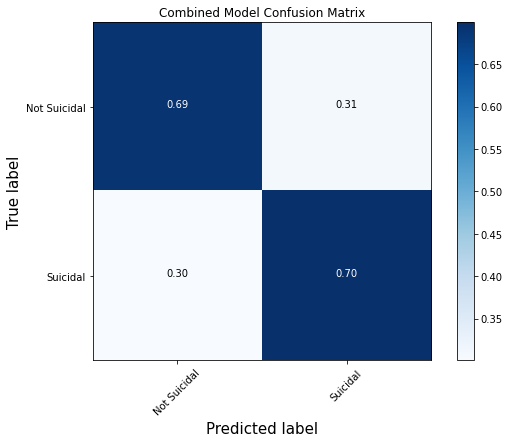

In [84]:
cnf_matrix = confusion_matrix(total_preds_df['decision_pred'], y_true1)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Suicidal','Suicidal'],normalize=True,
                      title='Combined Model Confusion Matrix')

In [72]:
# evaluate performcance based on group
types = total_preds_df.groupby('type')    
types = [types.get_group(x) for x in types.groups]

In [74]:
types[0].iloc[0].type

'hfhn'

In [77]:
def get_model_performances(df):
  group = df.iloc[0].type

  print(f'Geting predictions for group {group}')
  
  get_evaluation_metric(df['hfhn_hfln'], df['true'], 'HFHN + HFLN')
  get_evaluation_metric(df['hfln_lfln'], df['true'], 'HFLN + LFLN')
  get_evaluation_metric(df['lfln_lfhn'], df['true'], 'LFLN + LFHN')
  get_evaluation_metric(df['lfhn_hfhn'], df['true'], 'LFHN + HFHN')
  get_evaluation_metric(df['decision_pred'],df['true'], 'Combined')

  print("-----------------------------------")

In [78]:
for i in types:
  get_model_performances(i)

Geting predictions for group hfhn
For HFHN + HFLN -- F1_score :0.652, precision :0.67,  recall : 0.634, accuracy : 0.697
For HFLN + LFLN -- F1_score :0.648, precision :0.701,  recall : 0.602, accuracy : 0.678
For LFLN + LFHN -- F1_score :0.602, precision :0.541,  recall : 0.677, accuracy : 0.697
For LFHN + HFHN -- F1_score :0.667, precision :0.722,  recall : 0.619, accuracy : 0.695
For Combined -- F1_score :0.644, precision :0.588,  recall : 0.712, accuracy : 0.725
-----------------------------------
Geting predictions for group hfln
For HFHN + HFLN -- F1_score :0.907, precision :1.0,  recall : 0.829, accuracy : 0.833
For HFLN + LFLN -- F1_score :0.881, precision :0.868,  recall : 0.894, accuracy : 0.81
For LFLN + LFHN -- F1_score :0.848, precision :0.824,  recall : 0.875, accuracy : 0.762
For LFHN + HFHN -- F1_score :0.892, precision :0.971,  recall : 0.825, accuracy : 0.81
For Combined -- F1_score :0.882, precision :0.882,  recall : 0.882, accuracy : 0.81
----------------------------

In [89]:
test_df.groupby('type').count()

,username,hist_dates,combined_text,enc,label,split,tf_score,total_score
type,,,,,,,,
hfhn,459,459,459,459,459,459,459,459
hfln,84,84,84,84,84,84,84,84
lfhn,85,85,85,85,85,85,85,85
lfln,452,452,452,452,452,452,452,452
